# Smoothing and Forecasting

Tree rings from [Tree: Les Merveilles, France](https://datamarket.com/data/set/22r2/tree-les-merveilles-france-lade-larix-2150m-4402-00727#!ds=22r2&display=line) years: 988 to 1974


In [7]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

ts = pd.read_csv('../data/tree-rings.csv', parse_dates = ['year'], index_col = 'year', infer_datetime_format = True)
ts.head()

,rings
year,
988,1.484
989,1.119
990,1.057
991,1.081
992,1.073


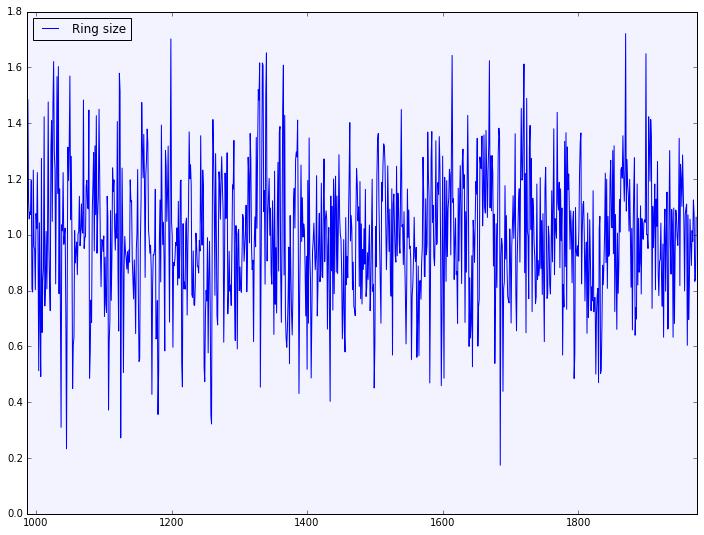

In [19]:
# Plot the time series

fig= plt.figure(figsize=(12,9))
plt.plot(ts.index, ts.rings, label = 'Ring size')
plt.xlim(xmin = min(ts.index)-1, xmax = max(ts.index) +1 )
plt.legend(loc='best')

# 1. Most Simple Forecast


$$ \hat{Y}_{n+1} = Y_n $$

Create a new column *simple* shifted by 1 sample so that 
    
    * ts.simple[0] = None
    * ts.simple[1] = ts.rings[0]
    * ...
    * ts.simple[n] = ts.rings[n-1]



# Metrics

How do we estimate quality of prediction?

Calculate:

* MSE with sklearn.metrics.mean_squared_error
* MAPE

        def mape(y_true, y_pred):
            return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


* MAD: with [pandas.DataFrame.mad](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mad.html)
        
        def mad(y_true, y_pred):
            return np.mean(np.abs(y_true - y_pred)) / len(y_true)


# 2. Moving average

Use the pandas series [Rolling](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.rolling.html) function

* Window size
* Centering: True

        ts.rings.rolling(window=7).mean()
        ts.rings.rolling(window=7, center= True).mean()

Exercise 1: Plot the series with different size of windows (5 to 25) on the same graph.

Exercize 2: Try different window size, calculate the different metrics, store the results in a dataframe and plot



In [ ]:
# 

# 3. Exponential moving average

Using ts.rings.ewm(alpha = \\( \alpha \\) ).mean() with \\(  0 \lt \alpha \leq 1 \\) 

* Plot the time serie with different values of \\( \alpha \\)
* Calculate MSE, MAD and MAPE 

Is that better than Simple Moving Average?

# 4. Autocorrelation

* Plot the autocorrelation of the tree rings with pandas [autocorrelation_plot()](http://pandas.pydata.org/pandas-docs/stable/visualization.html#visualization-autocorrelation)
* Load the Dow Jownes TS (../data/Dow-Jones.csv) , keep only data points since 2010 and plot the autocorrelation
* Load the average temperature data (../data/mean-daily-temperature.csv)  and plot the autocorrelation

Interpretation?



# 5. Partial Autocorrelation

Plot the Partial Autocorrelation for the 3 previous datasets.

Interpretation?

# 6. Stationarity test

Dickey Fuller test

        from statsmodels.tsa.stattools import adfuller
        def test_stationarity(timeseries):

            #Perform Dickey-Fuller test:
            print('Results of Dickey-Fuller Test:')
            dftest = adfuller(timeseries, autolag='AIC')

            dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
            for key,value in dftest[4].items():
                dfoutput['Critical Value (%s)'%key] = value
            print(dfoutput)

Then

        test_stationarity(ts.rings)
        test_stationarity(ts.temp)


What Ts is the most / least stationnary?
